In [1]:
using Pkg; Pkg.activate("..")

"/Users/markwang/github/credit_risk/Project.toml"

In [27]:
using Revise
using CreditRisk
using PyPlot
using Distributions
import Random

### Example showing necessity of mixture of factor shifts

In [3]:
m = 1000
t = 2
pk = 0.05
lk = 1
q = 0.3

a₁ = 0.7
a₂ = 0.65
b₁ = √0.51
b₂ = √0.57

α₁ = 1 - m^(-1/3)
α₂ = 1 - (log(m))^(-1/2)

Gh₁ = (α₁*invnormcdf(1-pk) + α₂*b₁*invnormcdf(q))/a₁
Gh₂ = (α₁*invnormcdf(1-pk) + α₂*b₂*invnormcdf(q))/a₂

Gh₁,Gh₂

(1.7833712308288552, 1.9001410771469178)

### Construct `Parameter`

In [17]:
N = 1000  # m
C = 2     # 2
S = 2     # d
l = 0.3   # q

cmm = zeros(N,C)
p = 0.05
cmm[:,1] .= p
cmm[:,2] .= 1-p

ead = zeros(N) .+ 1
lgc = zeros(N,C)
lgc[:,1] .= 1
lgc[:,2] .= 0
cn = fill(2,N)

β = zeros(N,C)
β[1:2:N,:] .= [0.7 0]
β[2:2:N,:] .= [0 0.65]
denom = @. sqrt(1 - $sum((β).^2, dims=2))
denom = dropdims(denom; dims=2)

# H[n, c] = inverse_unit_Gaussian(∑ᵧ cmm[c(n), γ])
cum_cmm = cumsum(cmm, dims=2)
H = invnormcdf.(cum_cmm)

weights = zeros(N,C)
weights = ead ./ sum(ead)
weights = weights .* lgc

param = Parameter(N, C, S, l, cmm, ead, lgc, cn, β, H, denom, weights)

Parameter (N=1000 C=2 S=2 l=0.3)


#### Visualize inner level objective function

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13447fdd8>

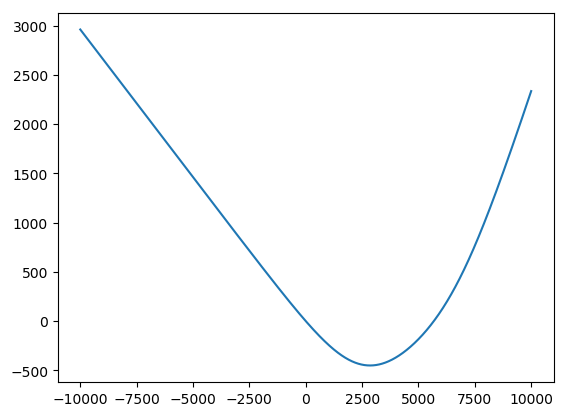

In [20]:
(N, C, S, l, cmm, ead, lgc, cn, β, H, denom, weights) = unpack(param)

Ψ = init_Ψ()

Zdist = MvNormal(S, 1)
Z = zeros(S)
pnc = zeros(N, C)
phi0 = zeros(N, C+1)
phi  = @view phi0[:,2:end]
twist = zeros(N, C)
mgf = zeros(N)
qnc = zeros(N, C)

Random.rand!(Zdist, Z)
@. phi = normcdf((H - $(β*Z)) / denom)
diff!(pnc, phi0; dims=2)

objective(θ) = begin
    θ = θ[1]
    Ψ(θ, pnc, weights) - θ*l
end

xs = -10000:10000
ys = [objective([x]) for x in xs]
display(plot(xs, ys))

### plot the upper bound $F_x(z)$ of $log P(L>x | Z=z)$


Tail bound approximation 

$$
P(L>l | Z=z) \leq e^{F_x(z)}
$$
The upper bond given by 
$$
Fₓ(z) = -θ_m(z)l + \psi(θ_m(z),z)
\quad\quad
\psi(\theta,z) = \sum_{n=1}^{N} \ln \sum_{c=1}^C p_n^c (z) e^{\theta w_n^c}
$$
where
$$
θ_m(z) = \underset{\theta\geq 0}{argmin} \{ -\theta l + \psi(\theta,z) \}
$$

In GL2005, outer level twisting amounts to finding `z` that

$$
\underset{z}{max} P(L>x | Z=z) e^{-\frac{1}{2}z^Tz}
\quad
\rightarrow
\quad
\underset{z}{max} \{F_x(z) - \frac{1}{2} z^Tz\}
$$

Here we want to plot 
$$
\begin{align*}
obj_1 &= Fₓ(z) \\
obj_2 &= -log(-F_x(z) + \frac{1}{2} z^Tz)
\end{align*}
$$

┌ Warning: `getindex(f::Figure, x)` is deprecated, use `getproperty(f, x)` instead.
│   caller = top-level scope at In[29]:36
└ @ Core In[29]:36
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[29]:37
└ @ Core In[29]:37
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[29]:39
└ @ Core In[29]:39
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[29]:40
└ @ Core In[29]:40
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` 

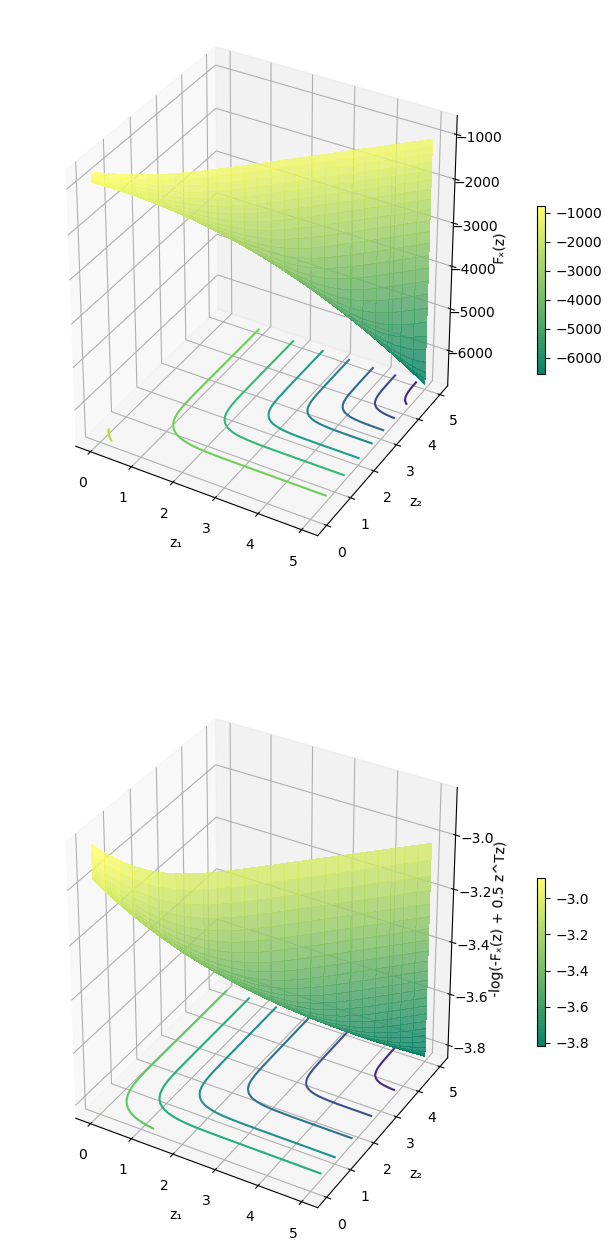

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[29]:47
└ @ Core In[29]:47
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[29]:49
└ @ Core In[29]:49
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[29]:50
└ @ Core In[29]:50
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[29]:51
└ @ Core In[29]:51
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in f

PyObject <matplotlib.colorbar.Colorbar object at 0x13addd8d0>

In [29]:
(N, C, S, loss, cmm, ead, lgc, cn, β, H, denom, weights) = unpack(param)

span = 5     # [0, range]
step = 0.1


phi0 = zeros(N, C+1)
phi  = @view phi0[:,2:end]
pnc = zeros(N, C)

Ψ = init_Ψ()
innerlevel = InnerLevelTwisting(N, C)

Fₓ(z) = begin
    @. phi = normcdf((H - $(β*z)) / denom)
    diff!(pnc, phi0; dims=2)
    twist!(innerlevel, pnc, weights, loss)
    θ = get_result(innerlevel)
    -θ*l + Ψ(θ, pnc, weights)
end

xs = 0:step:span
ys = 0:step:span
obj₁ = zeros(length(xs),length(ys))
obj₂ = zeros(length(xs),length(ys))

for i in 1:length(xs)
    for j in 1:length(ys)
        z = [xs[i]; ys[j]]
        obj₁[i,j] = Fₓ(z)
        obj₂[i,j] = -log10(-obj₁[i,j] + 0.5z'z)
    end
end

fig = figure(figsize=(8,16))
ax = fig[:add_subplot](2,1,1, projection = "3d")
# ax[:view_init](elev=0, azim=90+180)
sf=ax[:plot_surface](xs, ys, obj₁,alpha=0.8,cmap=ColorMap("summer"),antialiased=false)
ct=ax[:contour](xs, ys, obj₁,extend3d=false,zdir="z",offset=minimum(obj₁),stride=0.2)
ax[:set_xlabel]("z₁")
ax[:set_ylabel]("z₂")
ax[:set_zlabel]("Fₓ(z)")
fig[:colorbar](sf,shrink=0.3)

subplot(212)
ax = fig[:add_subplot](2,1,2, projection = "3d")
# ax[:view_init](elev=0, azim=90+180)
sf=ax[:plot_surface](xs, ys, obj₂,alpha=0.8,cmap=ColorMap("summer"),antialiased=false)
ct=ax[:contour](xs, ys, obj₂,extend3d=false,zdir="z",offset=minimum(obj₂),stride=0.2)
ax[:set_xlabel]("z₁")
ax[:set_ylabel]("z₂")
ax[:set_zlabel]("-log(-Fₓ(z) + 0.5 z^Tz)")
fig[:colorbar](sf,shrink=0.3)

#     savefig("surf_obj1.pdf", format="pdf")


In [ ]:
# nz = 1000
# ne = 1000
# est = CreditRisk.bernoulli_mc(param,(nz,ne))
# est